In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas

In [0]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('augment_spelling.txt',delimiter='\t',names = header)
    return data_set

def split_tweet(tweet):
    return tweet.split()    


In [0]:
data_set = get_data()

In [0]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

# inser padding character into glove embedding, we overwrite the first element and that's okay
# because we don't use the first element in our vocab
glove.vectors[0] = torch.tensor(np.zeros(50))

In [6]:
len(data_set)

11379

In [0]:
def data_set_to_glove_index(glove_dict):
    tweets_ints, encoded_labels = [],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        label = data_set['label'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        tweets_ints.append(idxs)
        encoded_labels.append(label)
    return tweets_ints, encoded_labels

In [0]:
tweets_ints, encoded_labels = data_set_to_glove_index(glove)

In [9]:
from collections import Counter
# outlier review stats
tweets_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length tweets: {}".format(tweets_lens[0]))
print("Maximum tweet length: {}".format(max(tweets_lens)))

Zero-length tweets: 0
Maximum tweet length: 38


In [0]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
seq_length = max(tweets_lens)

features = pad_features(tweets_ints, seq_length=seq_length)
encoded_labels = np.array(encoded_labels)

### Train, Validation, Test Split

In [0]:
from sklearn.utils import shuffle
features, encoded_labels = shuffle(features, encoded_labels)

In [13]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(9102, 38) 
Validation set: 	(1138, 38) 
Test set: 		(1138, 38)


### DataLoader and Batching

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [15]:
len(train_loader)

182

### Building the model

In [0]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, use_gpu):
        super(TweetLSTM, self).__init__()
        self.use_gpu = use_gpu
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size,bidirectional=True,batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes) # 2 * hidden_size because LSTM is bidrectional 
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        
        if self.use_gpu:
            h0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
            c0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
        else:
            h0 = torch.zeros(2, x.size(0), self.hidden_size)
            c0 = torch.zeros(2, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out
num_classes = 6
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)

In [17]:
def get_accuracy(model, data_loader, use_gpu):
    if use_gpu:
        model.cuda()
    correct, total = 0, 0
    for tweets, labels in data_loader:
        if use_gpu:
            tweets,labels  = tweets.cuda(), labels.cuda()
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)
  

get_accuracy(model, test_loader,use_gpu = True)


0.05272727272727273

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5,use_gpu=True):
    if use_gpu:
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], np.zeros(num_epochs)
    models = []
    epochs = []
    counter = 0
    for epoch in range(num_epochs):
        batch_loss = []
        for tweets, labels in train:
            if use_gpu:
                tweets,labels  = tweets.cuda(), labels.cuda()
            counter += 1
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(float(loss))
            if counter % 100 == 0:
                print("Step %d of Epoch: %d; Loss %f " % ( counter/100 ,epoch+1,np.mean(batch_loss)))
        counter = 0
        epoch_loss = np.mean(batch_loss)
        losses.append(epoch_loss)
        
        models.append(model.state_dict())
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader,use_gpu))
        valid_acc[epoch] = get_accuracy(model, valid_loader,use_gpu)
        
        print("Final Result for Epoch %d: Loss %f; Val Acc %f; Train Acc %f" % (
              epoch+1, epoch_loss, valid_acc[epoch], train_acc[-1]))
        print("-------------------------------------------------------------")
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return models, valid_acc

Step 1 of Epoch: 1; Loss 1.277567 
Final Result for Epoch 1: Loss 1.243901; Val Acc 0.580000; Train Acc 0.579231
-------------------------------------------------------------
Step 1 of Epoch: 2; Loss 1.171434 
Final Result for Epoch 2: Loss 1.164904; Val Acc 0.581818; Train Acc 0.587363
-------------------------------------------------------------
Step 1 of Epoch: 3; Loss 1.145573 
Final Result for Epoch 3: Loss 1.137703; Val Acc 0.578182; Train Acc 0.593516
-------------------------------------------------------------
Step 1 of Epoch: 4; Loss 1.126156 
Final Result for Epoch 4: Loss 1.127609; Val Acc 0.592727; Train Acc 0.604505
-------------------------------------------------------------
Step 1 of Epoch: 5; Loss 1.101537 
Final Result for Epoch 5: Loss 1.109329; Val Acc 0.590000; Train Acc 0.610549
-------------------------------------------------------------
Step 1 of Epoch: 6; Loss 1.087303 
Final Result for Epoch 6: Loss 1.097110; Val Acc 0.589091; Train Acc 0.615714
------------

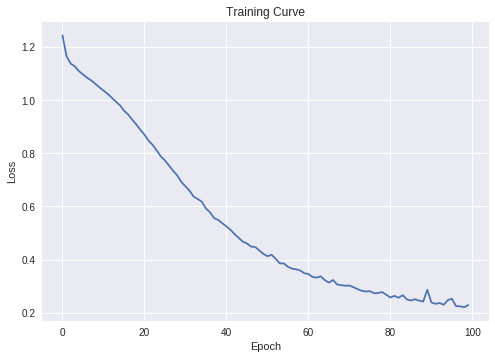

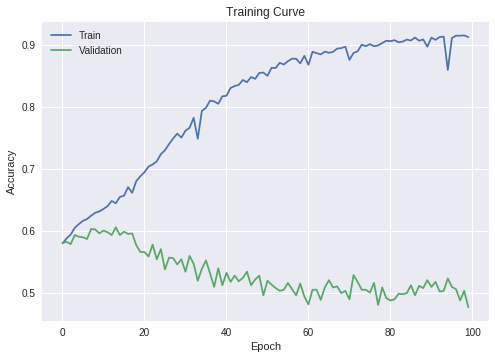

total training time: 180 s


In [19]:
import time
start = time.time()
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)
models, valids = train_rnn_network(model, train_loader, valid_loader, num_epochs=100, learning_rate=1e-3,use_gpu=True)
end = time.time()
print("total training time:", int(end -start), "s")

### Saving the model

In [21]:
print(np.argmax(valids))
torch.save(models[np.argmax(valids)], 'checkpoint_biLSTM.pth')

13


### Loading the model

In [0]:
state_dict = torch.load('checkpoint_biLSTM.pth')

In [0]:
model.load_state_dict(state_dict)

### Inference

In [0]:
# Tweet Test
happy_tweet = 'Im happy'
sad_tweet = 'Im sad'
angry = 'Im angry'
surprised_tweet = 'Im surprised'
disgusted_tweet = 'Im disgusted'
afraid_tweet = 'Im afraid'

In [0]:
def tweet_to_glove_index(tweet,glove_dict):
    tweets_ints = []
    tweet = tweet.lower()
    idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
    tweets_ints.append(idxs)
    return tweets_ints

In [0]:
int_to_emotion = {0:'Happy', 1:'Sad' , 2:'Angry', 3:'Surprised', 4:'Disgusted', 5:'Afraid'}

def predict(model, test_tweet, sequence_length=max(tweets_lens),use_gpu=True):
    
    
    # tokenize tweet
    test_ints = tweet_to_glove_index(test_tweet,glove)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    if use_gpu:
        feature_tensor = torch.from_numpy(features).cuda()
    else:
        feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    
    # get the output from the model
    output = model(feature_tensor)
    
    # convert output probabilities to predicted class (0 or 1)
    output_prob = nn.functional.softmax(output,dim=1)
    top_n_pred = output_prob.topk(3,dim=1) ## top 3 preds
    top_n_pred_prob, top_n_pred_index = top_n_pred[0].detach().cpu().numpy()[0], top_n_pred[1].detach().cpu().numpy()[0]
    print(test_tweet)
    print('Prediction:')
    for prob,index in zip(top_n_pred_prob,top_n_pred_index):
        print(int_to_emotion[index] , 'with' , str(int(prob*100))+"%", 'confidence')
    print('---------------')

In [27]:
predict(model,happy_tweet)
predict(model,sad_tweet)
predict(model,angry)
predict(model,surprised_tweet)
predict(model,disgusted_tweet)
predict(model,afraid_tweet)

Im happy
Prediction:
Sad with 91% confidence
Happy with 7% confidence
Disgusted with 0% confidence
---------------
Im sad
Prediction:
Sad with 98% confidence
Happy with 1% confidence
Disgusted with 0% confidence
---------------
Im angry
Prediction:
Happy with 77% confidence
Sad with 17% confidence
Surprised with 2% confidence
---------------
Im surprised
Prediction:
Disgusted with 46% confidence
Sad with 26% confidence
Angry with 10% confidence
---------------
Im disgusted
Prediction:
Happy with 38% confidence
Sad with 25% confidence
Angry with 20% confidence
---------------
Im afraid
Prediction:
Sad with 78% confidence
Happy with 18% confidence
Afraid with 2% confidence
---------------


In [0]:
tweets = ['Im so happy',
          'I feel so down today',
          'It boils my blood to see you',
         'wow what a nice car',
         'im sick of this shit',
         'theres a stranger at my home']

In [29]:
for tweet in tweets:
    predict(model, tweet)

Im so happy
Prediction:
Happy with 85% confidence
Sad with 11% confidence
Disgusted with 1% confidence
---------------
I feel so down today
Prediction:
Sad with 75% confidence
Disgusted with 14% confidence
Afraid with 4% confidence
---------------
It boils my blood to see you
Prediction:
Happy with 57% confidence
Sad with 42% confidence
Disgusted with 0% confidence
---------------
wow what a nice car
Prediction:
Happy with 99% confidence
Sad with 0% confidence
Afraid with 0% confidence
---------------
im sick of this shit
Prediction:
Sad with 89% confidence
Disgusted with 8% confidence
Angry with 1% confidence
---------------
theres a stranger at my home
Prediction:
Sad with 60% confidence
Happy with 39% confidence
Afraid with 0% confidence
---------------


In [30]:
tweets = ['You are so crazy',
          'You make me feel so cool',
          'I hate you',
          'you ruined my apetite',
          'that food was terrible']

for tweet in tweets:
    predict(model, tweet)

You are so crazy
Prediction:
Happy with 99% confidence
Sad with 0% confidence
Angry with 0% confidence
---------------
You make me feel so cool
Prediction:
Sad with 81% confidence
Happy with 18% confidence
Angry with 0% confidence
---------------
I hate you
Prediction:
Sad with 87% confidence
Happy with 8% confidence
Angry with 1% confidence
---------------
I HATE YOU
Prediction:
Sad with 87% confidence
Happy with 8% confidence
Angry with 1% confidence
---------------
you ruined my apetite
Prediction:
Angry with 69% confidence
Disgusted with 14% confidence
Happy with 9% confidence
---------------
that food was terrible
Prediction:
Sad with 49% confidence
Afraid with 32% confidence
Disgusted with 10% confidence
---------------


In [31]:
tweets = ['he said he will be there and he showed up','he said he will be there but he did not show up', 'he said he will be there and he showed up with his friends',
          'I lose', 'I have lost', 'I won', 'Live strong my guy', 'I am the best', 'I hate losing', 'I dont hate you', 'I do not hate you']
for tweet in tweets:
    predict(model, tweet)

he said he will be there and he showed up
Prediction:
Happy with 59% confidence
Afraid with 20% confidence
Angry with 13% confidence
---------------
he said he will be there but he did not show up
Prediction:
Happy with 99% confidence
Sad with 0% confidence
Disgusted with 0% confidence
---------------
he said he will be there and he showed up with his friends
Prediction:
Sad with 74% confidence
Happy with 23% confidence
Angry with 1% confidence
---------------
I lose
Prediction:
Happy with 96% confidence
Sad with 2% confidence
Disgusted with 0% confidence
---------------
I have lost
Prediction:
Sad with 98% confidence
Happy with 0% confidence
Angry with 0% confidence
---------------
I won
Prediction:
Happy with 87% confidence
Sad with 8% confidence
Disgusted with 3% confidence
---------------
Live strong my guy
Prediction:
Happy with 99% confidence
Sad with 0% confidence
Angry with 0% confidence
---------------
I am the best
Prediction:
Happy with 99% confidence
Angry with 0% confidenc